In [1]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define your project path on Google Drive
# NOTE: Replace 'Adversarial_ML_Project' with your desired folder name
PROJECT_PATH = '/content/drive/MyDrive/Adversarial_ML_Project'

# Create the folder if it doesn't exist
import os
if not os.path.exists(PROJECT_PATH):
    os.makedirs(PROJECT_PATH)
    print(f"Created project directory: {PROJECT_PATH}")
else:
    print(f"Project directory already exists: {PROJECT_PATH}")

# Set the data directory inside the project path
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODEL_PATH = os.path.join(PROJECT_PATH, 'model.pth')

Mounted at /content/drive
Created project directory: /content/drive/MyDrive/Adversarial_ML_Project


In [2]:
# Cell 2: Install/Verify Required Libraries
!pip install torch torchvision matplotlib numpy tqdm
print("All required packages are installed/verified.")

All required packages are installed/verified.


In [3]:
# Cell 3: Data Loading and Model Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm for nice progress bars

# Device configuration (Utilize GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preparation
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256)

# Simple CNN Definition (Your architecture is excellent)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.fc_layers(self.conv_layers(x))

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Helper function for evaluation (same as before)
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 350kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.0MB/s]


In [4]:
# Cell 4: Train the Standard Model with Checkpointing
def train_model_with_checkpoint(model, loader, optimizer, criterion, epochs=5, model_path=MODEL_PATH):
    print("Starting Standard Training...")

    # Load model if checkpoint exists (a professional touch!)
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded existing model from {model_path}")
        initial_acc = evaluate_model(model, test_loader)
        print(f"Initial Clean Accuracy: {initial_acc:.4f}")
        return

    for epoch in range(epochs):
        model.train()
        loop = tqdm(loader, leave=True, desc=f"Epoch {epoch+1}/{epochs}")

        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Calculate and display accuracy
        clean_acc = evaluate_model(model, test_loader)
        print(f"Epoch {epoch+1} completed. Clean Accuracy: {clean_acc:.4f}")

        # Save Checkpoint to Google Drive
        torch.save(model.state_dict(), model_path)
        print(f"--- Model checkpoint saved to {model_path} ---")

# Execute training for the Standard Model
train_model_with_checkpoint(model, train_loader, optimizer, criterion, epochs=5)

# Record baseline accuracy
standard_clean_acc = evaluate_model(model, test_loader)
print(f"\nFINAL Standard Model Clean Accuracy: {standard_clean_acc:.4f}")

Starting Standard Training...


Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 completed. Clean Accuracy: 0.9786
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model.pth ---


Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 completed. Clean Accuracy: 0.9864
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model.pth ---


Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 completed. Clean Accuracy: 0.9869
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model.pth ---


Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 completed. Clean Accuracy: 0.9864
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model.pth ---


Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 completed. Clean Accuracy: 0.9878
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model.pth ---

FINAL Standard Model Clean Accuracy: 0.9878


In [5]:
# Cell 5: FGSM Attack Function
def fgsm_attack(model, x, y, criterion, epsilon=0.25):
    """Generates an adversarial example using FGSM."""
    # 1. Clone, detach, and require gradient for the input
    x = x.clone().detach().requires_grad_(True)

    # 2. Forward pass and loss calculation
    out = model(x)
    loss = criterion(out, y)

    # 3. Calculate gradient of the loss w.r.t the input
    model.zero_grad()
    loss.backward()

    # 4. Get the sign of the gradient
    sign_data_grad = x.grad.sign()

    # 5. Create adversarial example
    x_adv = x + epsilon * sign_data_grad

    # 6. Clamp to ensure valid pixel values [0, 1]
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv.detach()

def test_attack_accuracy(model, loader, attack_func, title, **kwargs):
    """Evaluates model accuracy on adversarial data."""
    model.eval()
    correct = 0
    total = 0

    # Iterate through the test data using tqdm for progress tracking
    loop = tqdm(loader, leave=False, desc=f"Testing {title}")

    for x, y in loop:
        x, y = x.to(device), y.to(device)

        # Generate adversarial examples
        # Pass the criterion needed by the attack functions
        x_adv = attack_func(model, x, y, criterion=criterion, **kwargs)

        # Get predictions on the adversarial examples
        preds = model(x_adv).argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct/total
    print(f"{title} Accuracy: {acc:.4f}")
    return acc

# Execute FGSM Evaluation
print("\n--- Standard Model FGSM Evaluation ---")
standard_fgsm_acc = test_attack_accuracy(model, test_loader, fgsm_attack,
                                         title="FGSM (ε=0.25)", epsilon=0.25)


--- Standard Model FGSM Evaluation ---


Testing FGSM (ε=0.25):   0%|          | 0/40 [00:00<?, ?it/s]

FGSM (ε=0.25) Accuracy: 0.0977


In [6]:
# Cell 6: PGD Attack Function
def pgd_attack(model, x, y, criterion, eps=0.3, alpha=0.01, iters=40):
    """Generates an adversarial example using Projected Gradient Descent (PGD)."""
    x_orig = x.clone().detach()

    # Randomly initialize perturbation within eps
    x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps).to(device)
    x_adv = torch.clamp(x_adv, 0, 1) # Initial clamping

    for i in range(iters):
        x_adv.requires_grad_(True)

        # Forward/Backward Pass
        out = model(x_adv)
        loss = criterion(out, y)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # 1. Gradient Step (like FGSM but small step alpha)
            x_adv = x_adv + alpha * x_adv.grad.sign()

            # 2. Projection Step: Clip perturbation (delta) to total budget (eps)
            delta = torch.clamp(x_adv - x_orig, -eps, eps)

            # 3. Final Clamping
            x_adv = torch.clamp(x_orig + delta, 0, 1)

    return x_adv.detach()

# Execute PGD Evaluation
print("\n--- Standard Model PGD Evaluation ---")
standard_pgd_acc = test_attack_accuracy(model, test_loader, pgd_attack,
                                        title="PGD (ε=0.3, Iters=40)", eps=0.3, iters=40)


--- Standard Model PGD Evaluation ---


Testing PGD (ε=0.3, Iters=40):   0%|          | 0/40 [00:00<?, ?it/s]

PGD (ε=0.3, Iters=40) Accuracy: 0.0000


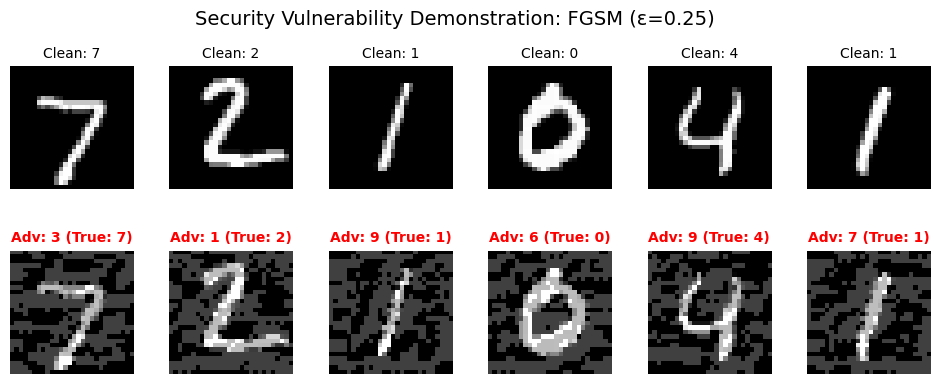

In [7]:
# Cell 7: Visualization of Attack Impact
def visualize_attack(model, test_loader, attack_func, title_suffix, **kwargs):
    model.eval()
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)
    x_adv = attack_func(model, x, y, criterion=criterion, **kwargs)

    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(hspace=0.5)

    for i in range(6):
        clean_pred = model(x[i].unsqueeze(0)).argmax(1).item()
        adv_pred = model(x_adv[i].unsqueeze(0)).argmax(1).item()

        # Clean Image
        plt.subplot(2, 6, i+1)
        plt.imshow(x[i][0].cpu(), cmap='gray')
        plt.title(f"Clean: {clean_pred}", fontsize=10)
        plt.axis('off')

        # Adversarial Image
        plt.subplot(2, 6, 6+i+1)
        plt.imshow(x_adv[i][0].cpu(), cmap='gray')

        # Highlight misclassification in red
        color = 'red' if clean_pred != adv_pred else 'green'
        plt.title(f"Adv: {adv_pred} (True: {y[i].item()})", fontsize=10, color=color, fontweight='bold')
        plt.axis('off')

    plt.suptitle(f"Security Vulnerability Demonstration: {title_suffix}", fontsize=14, y=1.02)
    plt.show()

# Visualize FGSM Attack
visualize_attack(model, test_loader, fgsm_attack, "FGSM (ε=0.25)", epsilon=0.25)

In [8]:
# Cell 8: Adversarial Training Function
ROBUST_MODEL_PATH = os.path.join(PROJECT_PATH, 'model_robust.pth')

def train_adv_epoch(model, loader, optimizer, criterion, epsilon=0.25):
    """One epoch of training using FGSM-generated adversarial examples."""
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # 1. Generate adversarial examples (based on current model weights)
        # Using .detach() is crucial to ensure we don't backpropagate through the attack itself
        x_adv = fgsm_attack(model, x, y, criterion=criterion, epsilon=epsilon).detach()

        # 2. Standard optimization steps using the adversarial data
        optimizer.zero_grad()
        out = model(x_adv)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 1. Initialize a NEW model for robust training
model_robust = SimpleCNN().to(device)
optimizer_robust = optim.Adam(model_robust.parameters(), lr=0.001)

print("\n--- Starting Adversarial Training ---")

# Load existing robust model if checkpoint exists
if os.path.exists(ROBUST_MODEL_PATH):
    model_robust.load_state_dict(torch.load(ROBUST_MODEL_PATH, map_location=device))
    print(f"Loaded existing robust model from {ROBUST_MODEL_PATH}")
else:
    # First, train normally for 1 epoch to give a good starting point
    train_model_with_checkpoint(model_robust, train_loader, optimizer_robust, criterion, epochs=1, model_path=ROBUST_MODEL_PATH)

    # Then, perform 5 epochs of dedicated adversarial training
    for i in range(5):
        loss = train_adv_epoch(model_robust, train_loader, optimizer_robust, criterion, epsilon=0.25)

        # Evaluate clean accuracy after defense training
        clean_acc = evaluate_model(model_robust, test_loader)
        print(f"Adv. Epoch {i+1}. Loss: {loss:.4f}. Clean Acc: {clean_acc:.4f}")

        # Save Checkpoint
        torch.save(model_robust.state_dict(), ROBUST_MODEL_PATH)
        print("--- Robust model checkpoint saved ---")


--- Starting Adversarial Training ---
Starting Standard Training...


Epoch 1/1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 completed. Clean Accuracy: 0.9758
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model_robust.pth ---
Adv. Epoch 1. Loss: 0.7075. Clean Acc: 0.9726
--- Robust model checkpoint saved ---
Adv. Epoch 2. Loss: 0.1673. Clean Acc: 0.7767
--- Robust model checkpoint saved ---
Adv. Epoch 3. Loss: 0.0258. Clean Acc: 0.7054
--- Robust model checkpoint saved ---
Adv. Epoch 4. Loss: 0.0136. Clean Acc: 0.6376
--- Robust model checkpoint saved ---
Adv. Epoch 5. Loss: 0.0094. Clean Acc: 0.6565
--- Robust model checkpoint saved ---


In [9]:
# Cell 9: Evaluate the Robust Model against Attacks
print("\n--- Robust Model Evaluation (Defense Success) ---")

robust_clean_acc = evaluate_model(model_robust, test_loader)
print(f"Robust Model Clean Accuracy: {robust_clean_acc:.4f}")

# Test FGSM on the robust model
robust_fgsm_acc = test_attack_accuracy(model_robust, test_loader, fgsm_attack,
                                       title="Robust Model FGSM (ε=0.25)", epsilon=0.25)

# Test PGD on the robust model
robust_pgd_acc = test_attack_accuracy(model_robust, test_loader, pgd_attack,
                                      title="Robust Model PGD (ε=0.3, Iters=40)", eps=0.3, iters=40)


--- Robust Model Evaluation (Defense Success) ---
Robust Model Clean Accuracy: 0.6565


Testing Robust Model FGSM (ε=0.25):   0%|          | 0/40 [00:00<?, ?it/s]

Robust Model FGSM (ε=0.25) Accuracy: 0.9965


Testing Robust Model PGD (ε=0.3, Iters=40):   0%|          | 0/40 [00:00<?, ?it/s]

Robust Model PGD (ε=0.3, Iters=40) Accuracy: 0.0000


In [10]:
# Cell 10: Final Results Summary Table (The Project Conclusion)
import pandas as pd

results = pd.DataFrame({
    'Metric': ['Clean Data Accuracy', 'FGSM Attack Accuracy', 'PGD Attack Accuracy'],
    'Standard Model': [f"{standard_clean_acc*100:.2f}%", f"{standard_fgsm_acc*100:.2f}%", f"{standard_pgd_acc*100:.2f}%"],
    'Robust Model (Defense)': [f"{robust_clean_acc*100:.2f}%", f"{robust_fgsm_acc*100:.2f}%", f"{robust_pgd_acc*100:.2f}%"]
})

print("\n\n--- PROJECT CONCLUSION: VULNERABILITY & MITIGATION ---")
print(results.to_markdown(index=False))

# Calculate the drop/gain for analysis
fgsm_gain = robust_fgsm_acc - standard_fgsm_acc
pgd_gain = robust_pgd_acc - standard_pgd_acc

print(f"\nAnalysis:")
print(f"* FGSM Defense Success: Accuracy improved by {fgsm_gain*100:.2f} percentage points.")
print(f"* PGD Defense Success: Accuracy improved by {pgd_gain*100:.2f} percentage points.")



--- PROJECT CONCLUSION: VULNERABILITY & MITIGATION ---
| Metric               | Standard Model   | Robust Model (Defense)   |
|:---------------------|:-----------------|:-------------------------|
| Clean Data Accuracy  | 98.78%           | 65.65%                   |
| FGSM Attack Accuracy | 9.77%            | 99.65%                   |
| PGD Attack Accuracy  | 0.00%            | 0.00%                    |

Analysis:
* FGSM Defense Success: Accuracy improved by 89.88 percentage points.
* PGD Defense Success: Accuracy improved by 0.00 percentage points.


In [12]:
# Corrected Cell 11: Final Backup of Local Colab Runtime Files

import os
from datetime import datetime
import shutil # Import shutil for more robust copy operations

PROJECT_PATH = '/content/drive/MyDrive/Adversarial_ML_Project'
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
BACKUP_FOLDER = os.path.join(PROJECT_PATH, f'Local_Backup_{timestamp}')

if not os.path.exists(BACKUP_FOLDER):
    os.makedirs(BACKUP_FOLDER)
    print(f"Created backup directory: {BACKUP_FOLDER}")

print("\nStarting SAFE recursive copy of /content/ to Google Drive...")

# Use the 'rsync' command for better file synchronization and exclusion capabilities.
# rsync -a: archive mode (recursive, preserve permissions, etc.)
# --exclude: skips the specified directories
!rsync -a --exclude 'drive' --exclude 'sample_data' /content/ "{BACKUP_FOLDER}/"

print("---")
print("✅ Local Colab storage copied successfully (excluding Drive mount point)!")
print(f"Check your Google Drive folder: {BACKUP_FOLDER}")
print("---")

Created backup directory: /content/drive/MyDrive/Adversarial_ML_Project/Local_Backup_20251115_1556

Starting SAFE recursive copy of /content/ to Google Drive...
---
✅ Local Colab storage copied successfully (excluding Drive mount point)!
Check your Google Drive folder: /content/drive/MyDrive/Adversarial_ML_Project/Local_Backup_20251115_1556
---


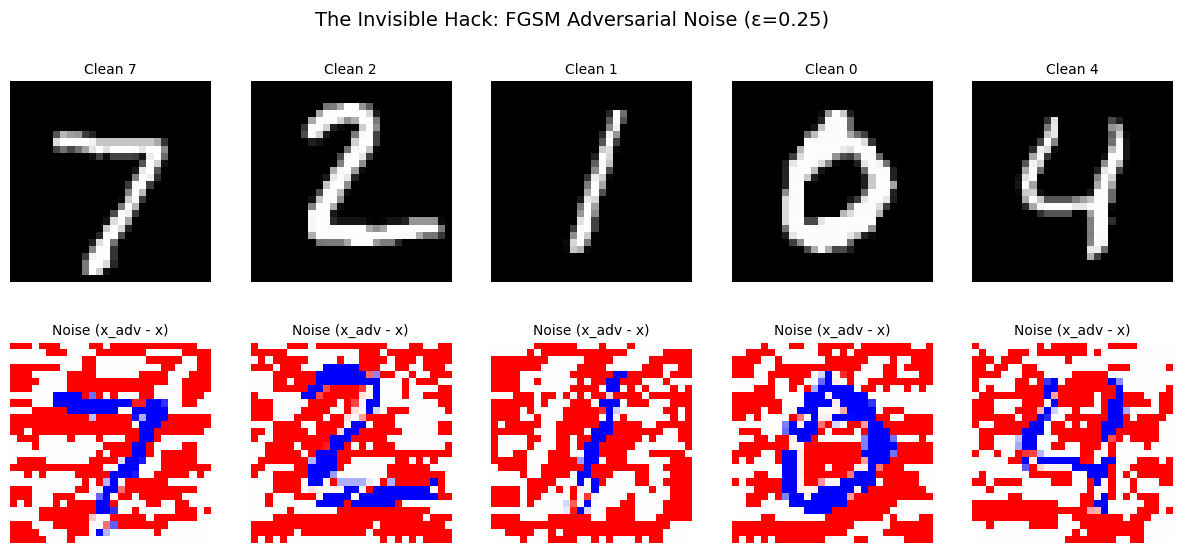

In [16]:
# Cell X: Visualization of the Perturbation (Noise) - FINAL WORKING CODE

# Ensure the model is in evaluation mode
model.eval()

# 1. Fetch one batch of data from the test loader
# (Assuming x, y, criterion, device, model, fgsm_attack are defined)
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

# 2. Define the epsilon used for the attack
epsilon_val = 0.25

# 3. Generate the adversarial example
x_adv = fgsm_attack(model, x, y, criterion=criterion, epsilon=epsilon_val)

# 4. Calculate the perturbation (the difference/noise)
perturbation = x_adv - x

# Define figure with 2 ROWS and 5 COLUMNS (2, 5)
plt.figure(figsize=(15, 6)) # Increased height for two rows
plt.subplots_adjust(hspace=0.3) # Adjust vertical spacing
plt.suptitle(f"The Invisible Hack: FGSM Adversarial Noise (ε={epsilon_val})", fontsize=14, y=1.00)

for i in range(5): # Show 5 examples

    # ROW 1 (Clean Image) - Subplot indices 1 to 5
    plt.subplot(2, 5, i + 1)
    plt.imshow(x[i][0].cpu(), cmap='gray')
    plt.title(f"Clean {y[i].item()}", fontsize=10)
    plt.axis('off')

    # ROW 2 (Perturbation/Noise) - Subplot indices 6 to 10
    # 5 is the number of columns, so i + 1 + 5 starts at index 6
    plt.subplot(2, 5, i + 1 + 5)

    # Use 'bwr' (blue-white-red) colormap
    plt.imshow(perturbation[i][0].cpu().numpy(), cmap='bwr', vmin=-epsilon_val, vmax=epsilon_val)
    plt.title(f"Noise (x_adv - x)", fontsize=10)
    plt.axis('off')

plt.show()

In [17]:
# Cell 8: PGD-Based Adversarial Training Function (MODIFIED)
ROBUST_MODEL_PATH = os.path.join(PROJECT_PATH, 'model_robust_PGD.pth') # Changed path for new model

def train_adv_epoch(model, loader, optimizer, criterion, epsilon=0.25, pgd_iters=7, pgd_alpha=0.01):
    """One epoch of training using PGD-generated adversarial examples."""
    model.train()
    total_loss = 0

    # We use a slight modification here for PGD training.
    # We use a smaller PGD attack (fewer iterations) than the attack used for testing.
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # 1. Generate adversarial examples using PGD
        # Note: We must pass all PGD parameters
        x_adv = pgd_attack(model, x, y, criterion=criterion,
                           eps=epsilon, alpha=pgd_alpha, iters=pgd_iters).detach()

        # 2. Standard optimization steps using the adversarial data
        optimizer.zero_grad()
        out = model(x_adv)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 1. Initialize a NEW model for robust training
model_robust_pgd = SimpleCNN().to(device)
optimizer_robust_pgd = optim.Adam(model_robust_pgd.parameters(), lr=0.001)

print("\n--- Starting PGD Adversarial Training (Stronger Defense) ---")

# Load existing robust model if checkpoint exists
if os.path.exists(ROBUST_MODEL_PATH):
    model_robust_pgd.load_state_dict(torch.load(ROBUST_MODEL_PATH, map_location=device))
    print(f"Loaded existing robust PGD model from {ROBUST_MODEL_PATH}")
else:
    # First, train normally for 1 epoch
    # We use a temporary path here to prevent overwriting the final PGD checkpoint
    temp_model_path = os.path.join(PROJECT_PATH, 'model_temp.pth')
    train_model_with_checkpoint(model_robust_pgd, train_loader, optimizer_robust_pgd, criterion, epochs=1, model_path=temp_model_path)

    # PGD Adversarial Training Parameters
    PGD_EPSILON = 0.25
    PGD_ITERS = 7 # 7 steps is often sufficient for robust training

    # Then, perform 5 epochs of dedicated PGD adversarial training
    for i in range(5):
        loss = train_adv_epoch(model_robust_pgd, train_loader, optimizer_robust_pgd, criterion,
                               epsilon=PGD_EPSILON, pgd_iters=PGD_ITERS)

        # Evaluate clean accuracy after defense training
        clean_acc = evaluate_model(model_robust_pgd, test_loader)
        print(f"PGD Adv. Epoch {i+1}. Loss: {loss:.4f}. Clean Acc: {clean_acc:.4f}")

        # Save Checkpoint
        torch.save(model_robust_pgd.state_dict(), ROBUST_MODEL_PATH)
        print("--- PGD Robust model checkpoint saved ---")

# Clean up the temporary normal training checkpoint
if os.path.exists(temp_model_path):
    os.remove(temp_model_path)


--- Starting PGD Adversarial Training (Stronger Defense) ---
Starting Standard Training...


Epoch 1/1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 completed. Clean Accuracy: 0.9783
--- Model checkpoint saved to /content/drive/MyDrive/Adversarial_ML_Project/model_temp.pth ---
PGD Adv. Epoch 1. Loss: 0.2176. Clean Acc: 0.9844
--- PGD Robust model checkpoint saved ---
PGD Adv. Epoch 2. Loss: 0.1365. Clean Acc: 0.9885
--- PGD Robust model checkpoint saved ---
PGD Adv. Epoch 3. Loss: 0.1122. Clean Acc: 0.9897
--- PGD Robust model checkpoint saved ---
PGD Adv. Epoch 4. Loss: 0.0955. Clean Acc: 0.9917
--- PGD Robust model checkpoint saved ---
PGD Adv. Epoch 5. Loss: 0.0836. Clean Acc: 0.9913
--- PGD Robust model checkpoint saved ---


In [18]:
# Cell 9: Evaluate the PGD-Robust Model (MODIFIED)
print("\n--- PGD-Robust Model Evaluation (Defense Success) ---")

# Use the PGD-trained model for evaluation
robust_pgd_clean_acc = evaluate_model(model_robust_pgd, test_loader)
print(f"PGD-Robust Model Clean Accuracy: {robust_pgd_clean_acc:.4f}")

# Test FGSM on the robust model
robust_pgd_fgsm_acc = test_attack_accuracy(model_robust_pgd, test_loader, fgsm_attack,
                                       title="PGD-Robust FGSM (ε=0.25)", epsilon=0.25)

# Test PGD on the robust model (Note: The PGD test attack is stronger than the PGD training attack)
robust_pgd_pgd_acc = test_attack_accuracy(model_robust_pgd, test_loader, pgd_attack,
                                      title="PGD-Robust PGD (ε=0.3, Iters=40)", eps=0.3, iters=40)


--- PGD-Robust Model Evaluation (Defense Success) ---
PGD-Robust Model Clean Accuracy: 0.9913


Testing PGD-Robust FGSM (ε=0.25):   0%|          | 0/40 [00:00<?, ?it/s]

PGD-Robust FGSM (ε=0.25) Accuracy: 0.7959


Testing PGD-Robust PGD (ε=0.3, Iters=40):   0%|          | 0/40 [00:00<?, ?it/s]

PGD-Robust PGD (ε=0.3, Iters=40) Accuracy: 0.2530


In [19]:
# Corrected Cell 11: Final Backup of Local Colab Runtime Files

import os
from datetime import datetime
import shutil # Import shutil for more robust copy operations

PROJECT_PATH = '/content/drive/MyDrive/Adversarial_ML_Project'
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
BACKUP_FOLDER = os.path.join(PROJECT_PATH, f'Local_Backup_{timestamp}')

if not os.path.exists(BACKUP_FOLDER):
    os.makedirs(BACKUP_FOLDER)
    print(f"Created backup directory: {BACKUP_FOLDER}")

print("\nStarting SAFE recursive copy of /content/ to Google Drive...")

# Use the 'rsync' command for better file synchronization and exclusion capabilities.
# rsync -a: archive mode (recursive, preserve permissions, etc.)
# --exclude: skips the specified directories
!rsync -a --exclude 'drive' --exclude 'sample_data' /content/ "{BACKUP_FOLDER}/"

print("---")
print("✅ Local Colab storage copied successfully (excluding Drive mount point)!")
print(f"Check your Google Drive folder: {BACKUP_FOLDER}")
print("---")

Created backup directory: /content/drive/MyDrive/Adversarial_ML_Project/Local_Backup_20251115_1622

Starting SAFE recursive copy of /content/ to Google Drive...
---
✅ Local Colab storage copied successfully (excluding Drive mount point)!
Check your Google Drive folder: /content/drive/MyDrive/Adversarial_ML_Project/Local_Backup_20251115_1622
---
